In [ ]:
!pip install transformers
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from transformers import CLIPProcessor, CLIPModel
import torch.nn.functional as F

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# the files containing the '.npy' files needed for problem 2
# e.g. '/content/drive/MyDrive/cs231a'
FOLDERNAME = 'random_sampling'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/MyDrive/$FOLDERNAME/
print('Files in this folder:')
%ls .

In [ ]:
device = 'cuda'

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

In [ ]:
import clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = 'ViT-L/14@336px'
model, preprocess = clip.load(model_name, device=device)

100%|███████████████████████████████████████| 891M/891M [00:23<00:00, 40.2MiB/s]


In [ ]:
# # load in the model
# model_name = "openai/clip-vit-large-patch14-336"
# model = CLIPModel.from_pretrained(model_name).to(device)
# processor = CLIPProcessor.from_pretrained(model_name)
# # text_prompt =["a photograph of an adult (or adults) and a child (or children) both looking at the same object
# text_prompt = "a photograph of an adult and a child both looking at the same object"
# text_input = processor(text=text_prompt, return_tensors="pt").to(device)

In [ ]:
# load in the model
# text_prompt =["a photograph of an adult (or adults) and a child (or children) both looking at the same object
text_prompt = [
    "a photograph of an adult and a child both looking at the same object",
    "a photograph of an adult and children both looking at the same object",
]
negative_prompt = [
    "a photograph of an adult and a child looking at the different objects",
    "a photograph of an adult and a child looking in different directions",
]
text_input = clip.tokenize(text_prompt).to(device)
negative_text_input = clip.tokenize(negative_prompt).to(device)

In [ ]:
# direct to my folder
import os

root_dir = "/content/drive/MyDrive/random_sampling"

In [ ]:
def pad_to_square(image, color=(0, 0, 0)):
    """Pad a PIL Image to make it square."""
    width, height = image.size
    if width == height:
        return image
    elif width > height:
        new_height = width
        new_width = width
    else:
        new_width = height
        new_height = height
    new_image = Image.new(image.mode, (new_width, new_height), color)
    new_image.paste(image, ((new_width - width) // 2, (new_height - height) // 2))
    return new_image

In [ ]:
yes = []
no = []
def get_sims():
  for filename in os.listdir(root_dir):
      if filename.endswith(".jpg"):
          # Load the image and encode it using the processor
          image_path = os.path.join(root_dir, filename)
          image = pad_to_square(Image.open(image_path))
          image_input = preprocess(image).to(device).unsqueeze(0)
          image_embedding = model.encode_image(image_input)
          image_embeddings = F.normalize(image_embedding, p=2, dim=1)

          # Calculate the similarity score between the image and text
          text_embedding = model.encode_text(text_input)
          text_embeddings = F.normalize(text_embedding, p=2, dim=1)
          similarity = (image_embeddings @ text_embeddings.T).max()

          negative_text_embedding = model.encode_text(text_input) 

          # Print the filename and similarity score
          # print(f"{filename}: {similarity.item()}")
          if "_y" in filename:
            yes.append(similarity.item())
          if "_n" in filename:
            no.append(similarity.item())
  return yes, no

def precision_recall(threshold, yes, no, eps=0.0001):
  tp = sum([y > threshold for y in yes])
  fp = sum([n > threshold for n in no])
  recall = tp/len(yes)
  precision = tp / (tp + fp + eps)
  return recall, precision

yes, no = get_sims()
x = []
y = []
n = 100000
for threshold in [i / n for i in range(n)]:
  r, p = (precision_recall(threshold, yes, no))
  if p > 0:
    y.append(p)
    x.append(r)

In [ ]:
p

0.0

Text(0, 0.5, 'Precision')

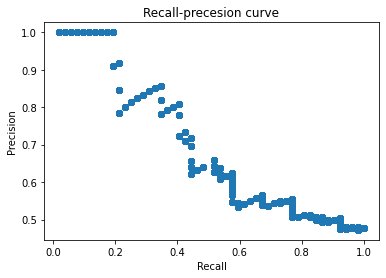

In [ ]:
import matplotlib.pyplot as plt
#x is recall and y is precision
plt.title("Recall-precesion curve")
plt.scatter(x, y)
plt.xlabel("Recall")
plt.ylabel("Precision")

Text(0, 0.5, 'Precision')

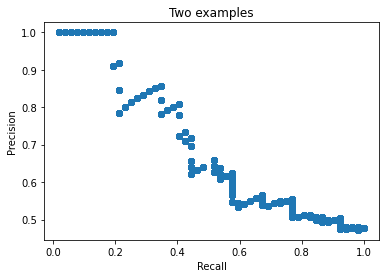

In [ ]:
import matplotlib.pyplot as plt
#x is recall and y is precision
plt.title("Two examples")
plt.scatter(x, y)
plt.xlabel("Recall")
plt.ylabel("Precision")

Text(0, 0.5, 'Precision')

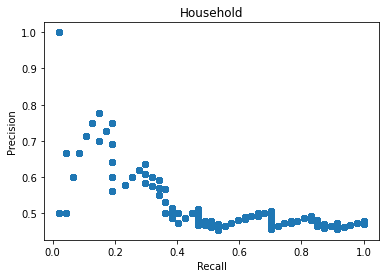

In [ ]:
import matplotlib.pyplot as plt
#x is recall and y is precision
plt.title("Household")
plt.scatter(x, y)
plt.xlabel("Recall")
plt.ylabel("Precision")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sort the data in ascending order
data_sorted = np.sort(sims)

# Calculate the ECDF
n = len(data_sorted)
y = np.arange(1, n+1) / n

# Plot the ECDF
plt.plot(data_sorted, y, marker='.', linestyle='none')

# Add labels and title
plt.xlabel('Data')
plt.ylabel('ECDF')
plt.title('Empirical CDF of Data')

# Show the plot
plt.show()
